<a href="https://colab.research.google.com/github/tayfununal/Uniform-Autoencoder-with-Latent-Flow-Matching/blob/main/UAE-with-LFM/generation/mnist_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/tayfununal/Uniform-Autoencoder-with-Latent-Flow-Matching.git

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch import Tensor

from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import os

print(os.getcwd())

%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/models/mnist_model.ipynb
%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/datasets/mnist_dataset.ipynb

# Flow Matching Model
%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/models/mnist_flow_model.ipynb

plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
# Hyper-Parameters & Settings
batch_size = 5000

In [ ]:
# Dataset
test_dataset = MNISTDataset(mode='test')
# DataLoader
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [ ]:
# Load the UAE model

path = '/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/mnist/UAE_MNIST'
model = torch.load(path + '.model', weights_only=False)
model.eval()

To_Uniform(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=2000, bias=True)
    (1): SiLU()
    (2): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=2000, out_features=2000, bias=True)
    (4): SiLU()
    (5): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=2000, out_features=2000, bias=True)
    (7): SiLU()
    (8): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=2000, out_features=2000, bias=True)
    (10): SiLU()
    (11): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=2000, out_features=3, bias=True)
    (13): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=2000, bias=True)
    (1): SiLU()
    (2): Linear(in_features=2000, out_features=2000, bias=True)
    (3): SiLU()
    (4): L

In [ ]:
# Create the "results" folder
os.makedirs("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/mnist", exist_ok=True)

flow_name = '/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/mnist/UAE_Latent_FM'
flow = torch.load(flow_name + '.model', weights_only=False)
flow.eval()

Flow(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=3, bias=True)
  )
)

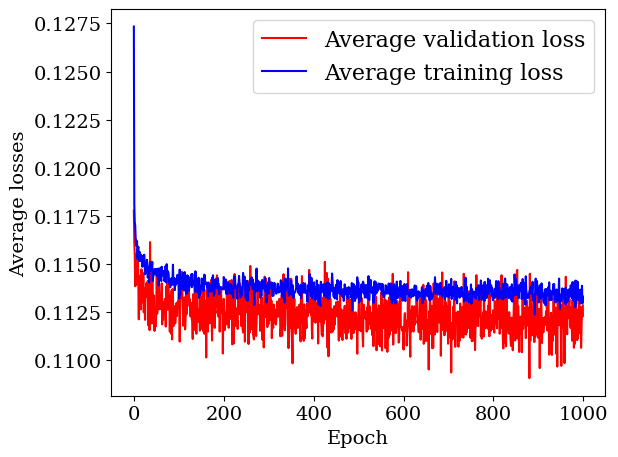

In [ ]:
# Load the losses
losses = np.loadtxt("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/mnist/losses.csv", delimiter=",", skiprows=1)
train_losses = losses[:, 0]
val_losses = losses[:, 1]

# Create a plot
plt.plot(val_losses, label="Average validation loss", c="red")
plt.plot(train_losses, label="Average training loss", c="blue")

plt.xlabel("Epoch")
plt.ylabel("Average losses")
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/mnist/average_losses_per_epoch.pdf")
plt.show()

In [ ]:
!pip uninstall -y plotly kaleido
!pip install plotly==5.24.1 kaleido==0.2.1

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Initialize uniform random data (3D)
x_uniform = torch.rand(len(test_dataset), 3)
n_steps = 8

# Create time steps
time_steps = torch.linspace(0, 1.0, n_steps + 1)

# Store data for each time step
data_at_each_step = []
titles = []

# Store initial data
data_at_each_step.append(x_uniform.detach().clone())
titles.append(f't = {time_steps[0]:.2f}')

# Generate data for each step
for i in range(n_steps):
    x_uniform = flow.step(x_t=x_uniform, t_start=time_steps[i], t_end=time_steps[i + 1])
    data_at_each_step.append(x_uniform.detach().clone())
    titles.append(f't = {time_steps[i + 1]:.2f}')

# Create subplots - all in one row
cols = n_steps + 1
rows = 1

# Create subplot specifications
specs = [[{'type': 'scatter3d'} for _ in range(cols)]]

fig = make_subplots(
    rows=rows,
    cols=cols,
    specs=specs,
    subplot_titles=titles,
    horizontal_spacing=0.008
)

# Add traces for each time step
for i, (data, title) in enumerate(zip(data_at_each_step, titles)):
    col = i + 1

    fig.add_trace(
        go.Scatter3d(
            x=data[:, 0],
            y=data[:, 1],
            z=data[:, 2],
            mode='markers',
            marker=dict(
                size=4,
                color='blue',
                opacity=1.0
            ),
            name=f'Step {i}',
            showlegend=False
        ),
        row=1,
        col=col
    )

# Update layout for each subplot
font_style = dict(family='Times New Roman', size=16)
for i in range(len(data_at_each_step)):
    scene_name = f'scene{"" if i == 0 else i + 1}'
    fig.update_layout({
        scene_name: dict(
            xaxis_title='x₁',
            yaxis_title='x₂',
            zaxis_title='x₃',
            xaxis=dict(
                title_font=font_style,
                range=[0, 1]
            ),
            yaxis=dict(
                title_font=font_style,
                range=[0, 1]
            ),
            zaxis=dict(
                title_font=font_style,
                range=[0, 1]
            ),
            camera=dict(eye=dict(x=1.8, y=1.8, z=1.8))
        )
    })

# Update overall layout
fig.update_layout(
    width=200 * (n_steps + 1),  # Dynamic width based on number of steps
    height=250,
    margin=dict(t=30, b=20, l=20, r=20),
    font=dict(family='Times New Roman', size=12),
    showlegend=False
)

fig.update_traces(marker=dict(size=2))

# Save and show
fig.write_image("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/mnist/mnist_FM_latent_result_along_time.pdf")
fig.show()

In [ ]:
import torch
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data preparation
x_1 = model.encoder(next(iter(test_loader))[0])

# Create two side-by-side 3D subplots
fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    horizontal_spacing=0.05
)

# Left plot - UAE (3D)
fig.add_trace(
    go.Scatter3d(
        x=x_1[:, 0].detach().numpy(),
        y=x_1[:, 1].detach().numpy(),
        z=x_1[:, 2].detach().numpy() if x_1.shape[1] > 2 else torch.zeros(x_1.shape[0]).numpy(),
        mode='markers',
        marker=dict(
            size=4,
            color='blue',
            opacity=1.0
        ),
        name='UAE',
        showlegend=False
    ),
    row=1, col=1
)

# Right plot - Flow Matching (3D)
fig.add_trace(
    go.Scatter3d(
        x=x_uniform[:, 0].detach().numpy(),
        y=x_uniform[:, 1].detach().numpy(),
        z=x_uniform[:, 2].detach().numpy() if x_uniform.shape[1] > 2 else torch.zeros(x_uniform.shape[0]).numpy(),
        mode='markers',
        marker=dict(
            size=4,
            color='red',
            opacity=1.0
        ),
        name='Flow Matching',
        showlegend=False
    ),
    row=1, col=2
)

# Font settings
font_style = dict(family='Times New Roman', size=16)

# 3D scene settings for each subplot
for i in range(1, 3):
    scene_name = f'scene{"" if i == 1 else i}'
    fig.update_layout({
        scene_name: dict(
            xaxis_title='z₁',
            yaxis_title='z₂',
            zaxis_title='z₃',
            xaxis=dict(
                title_font=font_style,
                range=[0, 1]
            ),
            yaxis=dict(
                title_font=font_style,
                range=[0, 1]
            ),
            zaxis=dict(
                title_font=font_style,
                range=[0, 1]
            ),
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
        )
    })

# General layout settings
fig.update_layout(
    width=600,
    height=250,
    margin=dict(t=10, b=20, l=20, r=20),
    font=dict(family='Times New Roman', size=12),
    showlegend=False
)

# Save and show
fig.write_image("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/mnist/mnist_FM_latent_vs_UAE_latent.pdf")
fig.show()

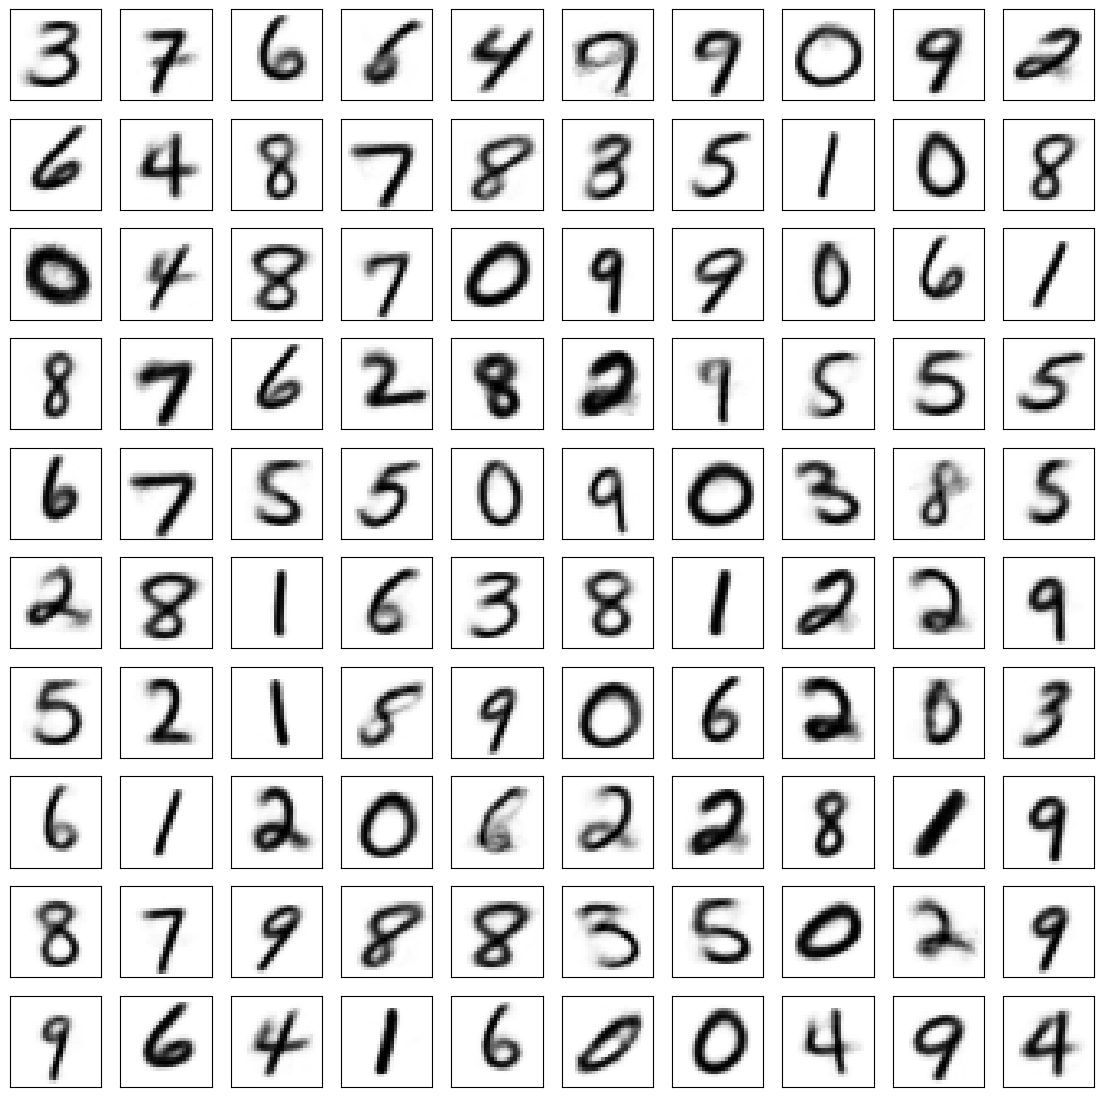

In [ ]:
# Decode
x_hat = model.decoder(x_uniform)

# Plot
fig, axs = plt.subplots(10, 10, figsize=(14, 14), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
    img = x_hat[i].detach().cpu().numpy().reshape(28, 28)
    ax.imshow(img, cmap='binary')

plt.savefig('/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/mnist/mnist_mlp_veri_uretimi_3d_latent.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()